In [2]:
import pandas as pd
import datetime
import gc
from sklearn.ensemble import (
BaggingRegressor, RandomForestRegressor, AdaBoostRegressor)
from sklearn.metrics import mean_squared_error
from technical_indicators import * # import all function
from sklearn.model_selection import TimeSeriesSplit
import parfit as pf
from sklearn.metrics import r2_score
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn import linear_model

In [52]:
# read in our data
url = "https://raw.githubusercontent.com/meenmo/Stat479_Project/master/Data/IBM.csv"
df_ORIGINAL = pd.read_csv(url)

### Clean Data

In [53]:
df_features = df_ORIGINAL
df_features['Date'] = pd.to_datetime(df_features['Date'])
df_features.head()

Date        High         Low        Open       Close   Volume  \
0 2002-01-02  121.500000  119.800003  120.599999  121.500000  6862800   
1 2002-01-03  124.220001  120.250000  121.500000  123.660004  8621700   
2 2002-01-04  125.599999  123.980003  124.050003  125.599999  8405200   
3 2002-01-07  126.190002  123.699997  125.000000  124.050003  5939600   
4 2002-01-08  125.199997  123.730003  124.250000  124.699997  5311800   

   Adj Close  
0  84.677422  
1  86.182800  
2  87.534859  
3  86.454575  
4  86.907600

In [168]:
### Create Lag Features
# this is exactly what the book does for create_lag_features from chapter 29
def create_lag_features(df, lag_days):
    df_ret = df.copy()
    
    # calculate today's percentage lag
#     df_ret['Today'] = np.nan
#     for i in range(1,len(df)):
#         df_ret['Today'][i]=(df_ret['Adj Close'][i]/df_ret['Adj Close'][i-1])-1 
    
    # iterate through the lag days to generate lag values up to lag_days + 1
    for i in range(1,lag_days + 1):
        df_lag = df_ret[['Date', 'Adj Close']].copy()
        # generate dataframe to shift index by i day. 415 is number of stocks
        df_lag['Date'] = df_lag['Date'].shift(-1)
        df_lag.columns = ['Date', 'lag' + str(i)]
        # combine the valuelag
        df_ret = pd.merge(df_ret, df_lag, how = 'left', left_on = ['Date'], right_on = ['Date'])
    
    #frees memory
    del df_lag
    
    df_ret['Today'] = (df_ret['Adj Close'] / df_ret['lag1'])-1
    
    for i in range(2,lag_days+1):
        df_ret['lag'+str(i)]=df_ret['lag'+str(i)].shift(i-1)
        
    df_ret = df_ret[['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Today','lag1', 'lag2', 'lag3', 'lag4', 'lag5']]
    df_ret = df_ret.iloc[lag_days:]
    return df_ret

In [192]:
# Sanity Check
df_1 = create_lag_features(df_features, 5)
df_1.head(7)


Date        High         Low        Open       Close    Volume  \
5  2002-01-09  126.389999  124.150001  124.699997  124.489998   6839900   
6  2002-01-10  124.000000  121.419998  123.750000  122.139999   8926300   
7  2002-01-11  122.180000  120.279999  121.500000  120.309998   4797800   
8  2002-01-14  120.089996  117.099999  120.000000  118.050003  10026700   
9  2002-01-15  119.699997  117.720001  118.050003  118.849999   5647900   
10 2002-01-16  118.750000  117.250000  118.000000  117.400001   5366300   
11 2002-01-17  120.550003  117.260002  119.849999  119.900001  11153700   

    Adj Close     Today       lag1       lag2       lag3       lag4       lag5  
5   86.761269 -0.001684  86.907600  86.454575  87.534859  86.182800  84.677422  
6   85.123428 -0.018878  86.761269  86.907600  86.454575  87.534859  86.182800  
7   83.848038 -0.014983  85.123428  86.761269  86.907600  86.454575  87.534859  
8   82.273003 -0.018784  83.848038  85.123428  86.761269  86.907600  86.454575  
9   82.830559  0.006777  82.273003  83.848038  85.123428  86.761269  86.907600  
10  81.819984 -0.012201  82.830559  82.273003  83.848038  85.123428  86.761269  
11  83.562317  0.021295  81.819984  82.830559  82.273003  83.848038  85.123428

In [185]:
def retrieve_dataset_for_one(df):
    # selecting dataframe
    X_one = df 
    
#     # rename columns in dataframe
#     a = ['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close', 'Today']
#     for i in range(1,len(list(df))-7):
#         a.append('lag' + str(i))
        
#     X_one.columns = a

    X_one = X_one.reset_index(drop = True)
    
    X_one = standard_deviation(X_one, 14)

    X_one = relative_strength_index(X_one, 14) # periods
    X_one = average_directional_movement_index(X_one, 14, 13) # n, n_ADX
    X_one = moving_average(X_one, 21) # periods
    X_one = exponential_moving_average(X_one, 21) # periods
    X_one = momentum(X_one, 14) # 

    X_one = average_true_range(X_one, 14)
    X_one = bollinger_bands(X_one, 21)
    X_one = ppsr(X_one)
    X_one = stochastic_oscillator_k(X_one)
    X_one = stochastic_oscillator_d(X_one, 14)
    X_one = trix(X_one, 14)
    X_one = macd(X_one, 26, 12)
    X_one = mass_index(X_one)
    X_one = vortex_indicator(X_one, 14)

    X_one = kst_oscillator(X_one, 10, 10, 10, 15, 10, 15, 20, 30)
    X_one = true_strength_index(X_one, 25, 13)

    #X_one = accumulation_distribution(X_one, 14) # Causes Problems, apparently
    X_one = chaikin_oscillator(X_one)
    X_one = money_flow_index(X_one, 14)
    X_one = on_balance_volume(X_one, 14)
    X_one = force_index(X_one, 14)
    X_one = ease_of_movement(X_one, 14)
    X_one = commodity_channel_index(X_one, 14)
    X_one = keltner_channel(X_one, 14)
    X_one = ultimate_oscillator(X_one)
    X_one = donchian_channel(X_one, 14)
    
    # drop earlier data with missing lag features
    X_one.dropna(inplace=True)
    X_one = X_one.reset_index(drop = True)
    
    return X_one

In [186]:
retrieve_dataset_for_one(df_1).head()

Date        High         Low        Open       Close    Volume  \
0 2002-03-13  108.650001  106.699997  108.300003  107.180000   6409200   
1 2002-03-14  107.949997  106.589996  107.019997  106.599999   5335500   
2 2002-03-15  107.449997  105.589996  106.550003  106.790001  10864100   
3 2002-03-18  108.639999  106.230003  107.099999  106.349999   5301200   
4 2002-03-19  108.050003  106.489998  106.849999  107.489998   4614800   

   Adj Close     Today       lag1       lag2     ...         MFI_14  \
0  74.795845 -0.012166  75.717003  73.441994     ...       0.714286   
1  74.391068 -0.005412  74.795845  75.717003     ...       0.642857   
2  74.523666  0.001782  74.391068  74.795845     ...       0.571429   
3  74.216637 -0.004120  74.523666  74.391068     ...       0.642857   
4  75.012154  0.010719  74.216637  74.523666     ...       0.642857   

         OBV_14      Force_14        EoM_14    CCI_14   KelChM_14   KelChU_14  \
0  3.091543e+06 -4.020301e+07  2.272485e-07  1.199477  102.793809  105.742380   
1  1.962464e+06 -4.185922e+07  2.286739e-07  0.944585  103.454047  106.254047   
2  3.445814e+06  8.161435e+06  2.086708e-07  0.716336  104.053094  106.833809   
3  3.898193e+06 -5.826634e+07  2.500726e-07  0.753866  104.740952  107.465237   
4  3.372200e+06 -7.113525e+07  2.263920e-07  0.770933  105.388333  107.966189   

    KelChD_14  Ultimate_Osc  Donchian_14  
0   99.845238      3.642056    13.389999  
1  100.654047      3.354306    13.389999  
2  101.272380      3.339650    13.389999  
3  102.016666      3.416617    13.389999  
4  102.810476      3.647240    13.389999  

[5 rows x 50 columns]

In [9]:
#???
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
#stockindataset = list(df_comb['Ticker'])
df_comb['Ticker'] = le.fit_transform(stockindataset)

### DT Model

#### Train-Test Split

READ THIS - https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

1) __Train-Test__ split that respect temporal order of observations.  
2) __Multiple Train-Test__ splits that respect temporal order of observations.  
3) __Walk-Forward Validation__ where a model may be updated each time step new data is received.  

In [188]:
df_1.head()

Date        High         Low        Open       Close    Volume  \
5 2002-01-09  126.389999  124.150001  124.699997  124.489998   6839900   
6 2002-01-10  124.000000  121.419998  123.750000  122.139999   8926300   
7 2002-01-11  122.180000  120.279999  121.500000  120.309998   4797800   
8 2002-01-14  120.089996  117.099999  120.000000  118.050003  10026700   
9 2002-01-15  119.699997  117.720001  118.050003  118.849999   5647900   

   Adj Close     Today       lag1       lag2       lag3       lag4       lag5  
5  86.761269 -0.001684  86.907600  86.454575  87.534859  86.182800  84.677422  
6  85.123428 -0.018878  86.761269  86.907600  86.454575  87.534859  86.182800  
7  83.848038 -0.014983  85.123428  86.761269  86.907600  86.454575  87.534859  
8  82.273003 -0.018784  83.848038  85.123428  86.761269  86.907600  86.454575  
9  82.830559  0.006777  82.273003  83.848038  85.123428  86.761269  86.907600

In [195]:
# do time series split DOING NUMBER 2
splits = TimeSeriesSplit(n_splits=5)

# stores all labels
y = df_1['Today']
y.head()

5   -0.001684
6   -0.018878
7   -0.014983
8   -0.018784
9    0.006777
Name: Today, dtype: float64

In [196]:
# drop columns not being used
df_1.drop(['Open','Close','Low','High','Today'], axis = 1, inplace = True)

In [201]:
# creates all test data which is all after may 2016
X_test = df_1.loc[(df_1['Date'] >= '2018-01-01'),:]
y_test = y[X_test.index]

           Date   Volume   Adj Close        lag1        lag2        lag3  \
4028 2018-01-02  4202500  147.574875  146.780777  147.373947  146.503357   
4029 2018-01-03  9441600  151.631393  147.574875  146.780777  147.373947   
4030 2018-01-04  7556200  154.702484  151.631393  147.574875  146.780777   
4031 2018-01-05  5195800  155.458298  154.702484  151.631393  147.574875   
4032 2018-01-08  5237500  156.395889  155.458298  154.702484  151.631393   

            lag4        lag5  
4028  146.216324  145.900604  
4029  146.503357  146.216324  
4030  147.373947  146.503357  
4031  146.780777  147.373947  
4032  147.574875  146.780777  
4028    0.005410
4029    0.027488
4030    0.020254
4031    0.004886
4032    0.006031
Name: Today, dtype: float64


In [230]:
df_1[df_1['Date'] <= '2017-12-31'].head()

Date    Volume  Adj Close       lag1       lag2       lag3       lag4  \
5 2002-01-09   6839900  86.761269  86.907600  86.454575  87.534859  86.182800   
6 2002-01-10   8926300  85.123428  86.761269  86.907600  86.454575  87.534859   
7 2002-01-11   4797800  83.848038  85.123428  86.761269  86.907600  86.454575   
8 2002-01-14  10026700  82.273003  83.848038  85.123428  86.761269  86.907600   
9 2002-01-15   5647900  82.830559  82.273003  83.848038  85.123428  86.761269   

        lag5  
5  84.677422  
6  86.182800  
7  87.534859  
8  86.454575  
9  86.907600

In [229]:
df_1.loc[(df_1['Date'] <= uniq_date[len(train_index) - 1]),:].head()


Date    Volume  Adj Close       lag1       lag2       lag3       lag4  \
5 2002-01-09   6839900  86.761269  86.907600  86.454575  87.534859  86.182800   
6 2002-01-10   8926300  85.123428  86.761269  86.907600  86.454575  87.534859   
7 2002-01-11   4797800  83.848038  85.123428  86.761269  86.907600  86.454575   
8 2002-01-14  10026700  82.273003  83.848038  85.123428  86.761269  86.907600   
9 2002-01-15   5647900  82.830559  82.273003  83.848038  85.123428  86.761269   

        lag5  
5  84.677422  
6  86.182800  
7  87.534859  
8  86.454575  
9  86.907600

In [231]:
trainsamples = []
model1metrics = []
model2metrics = []
model3metrics = []
model4metrics = []

uniq_date = df_1['Date']
for train_index, test_index in splits.split(uniq_date):
    # do the split for train
    X_train = df_1.loc[(df_1['Date'] <= uniq_date[len(train_index) - 1]),:]
    y_train = y[X_train.index]

    # do the split for test
    X_val = df_1.loc[(df_1['Date'] > uniq_date[len(train_index) - 1]) & (df_1['Date'] <= '2016-05-31'),:]
    y_val = y[X_val.index]

    # drop date
    X_train.drop(['Date'], axis = 1, inplace = True)
    X_val.drop(['Date'], axis = 1, inplace = True)

    # print some useful info
    print('Observations: ', (X_train.shape[0] + X_test.shape[0]))
    print('Cutoff date: ', uniq_date[len(train_index) - 1])
    print('Training Observations: ', (X_train.shape[0]))
    print('Testing Observations: ', (X_test.shape[0]))
    
    trainsamples.append(X_train.shape[0])
    
    # random forest regression based on default parameter
    rf = RandomForestRegressor(random_state = 0)
    rf.fit(X_train, y_train)
    model1metrics.append([mean_squared_error(y_val, rf.predict(X_val)),r2_score(y_val, rf.predict(X_val))])
    
    # bagging based on default parameter
    bag = BaggingRegressor(DecisionTreeRegressor())
    bag.fit(X_train, y_train)
    model2metrics.append([mean_squared_error(y_val, bag.predict(X_val)),r2_score(y_val, bag.predict(X_val))])
    
    # boosting on default parameter
    boost = AdaBoostRegressor(DecisionTreeRegressor(), random_state = 0, learning_rate=0.01)
    boost.fit(X_train, y_train)
    model3metrics.append([mean_squared_error(y_val, boost.predict(X_val)),r2_score(y_val, boost.predict(X_val))])
    
    # linear regression on default parameter
    lr = linear_model.LinearRegression()
    lr.fit(X_train, y_train)
    model4metrics.append([mean_squared_error(y_val, lr.predict(X_val)),r2_score(y_val, lr.predict(X_val))])

c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Observations:  917
Cutoff date:  2004-10-26 00:00:00
Training Observations:  705
Testing Observations:  212


c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Observations:  1622
Cutoff date:  2007-08-15 00:00:00
Training Observations:  1410
Testing Observations:  212


c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Observations:  2327
Cutoff date:  2010-06-03 00:00:00
Training Observations:  2115
Testing Observations:  212


c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Observations:  3032
Cutoff date:  2013-03-22 00:00:00
Training Observations:  2820
Testing Observations:  212


c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\meenm\appdata\local\programs\python\python36\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Observations:  3737
Cutoff date:  2016-01-08 00:00:00
Training Observations:  3525
Testing Observations:  212


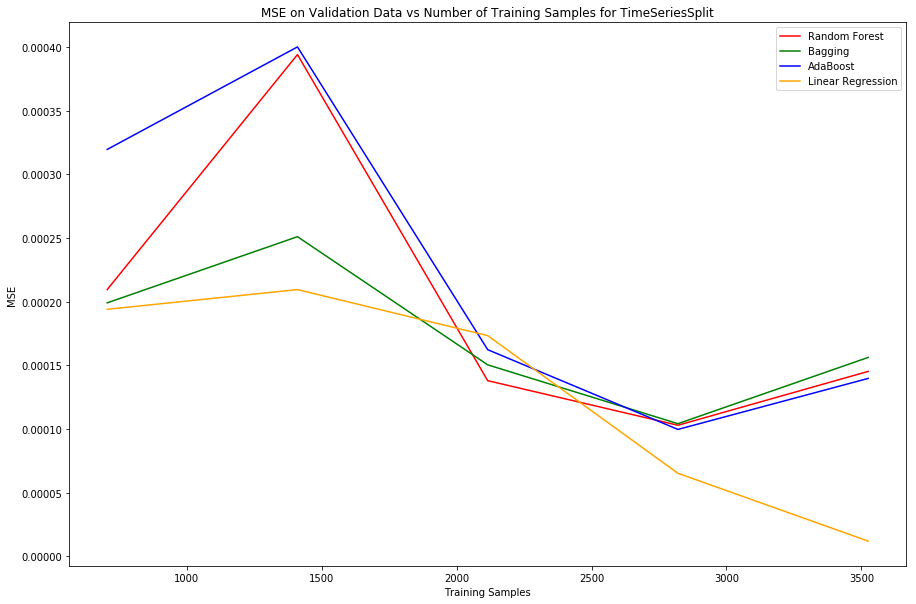

In [237]:
plt.plot(trainsamples,[item[0] for item in model1metrics], color = 'r', label = 'Random Forest')
plt.plot(trainsamples,[item[0] for item in model2metrics], color = 'g', label = 'Bagging')
plt.plot(trainsamples,[item[0] for item in model3metrics], color = 'b', label = 'AdaBoost')
plt.plot(trainsamples,[item[0] for item in model4metrics], color = 'orange', label = 'Linear Regression')

plt.title('MSE on Validation Data vs Number of Training Samples for TimeSeriesSplit')
plt.xlabel('Training Samples')
plt.ylabel('MSE')
plt.legend()

#plt.rcParams['figure.figsize'] = [15,10]

plt.show()

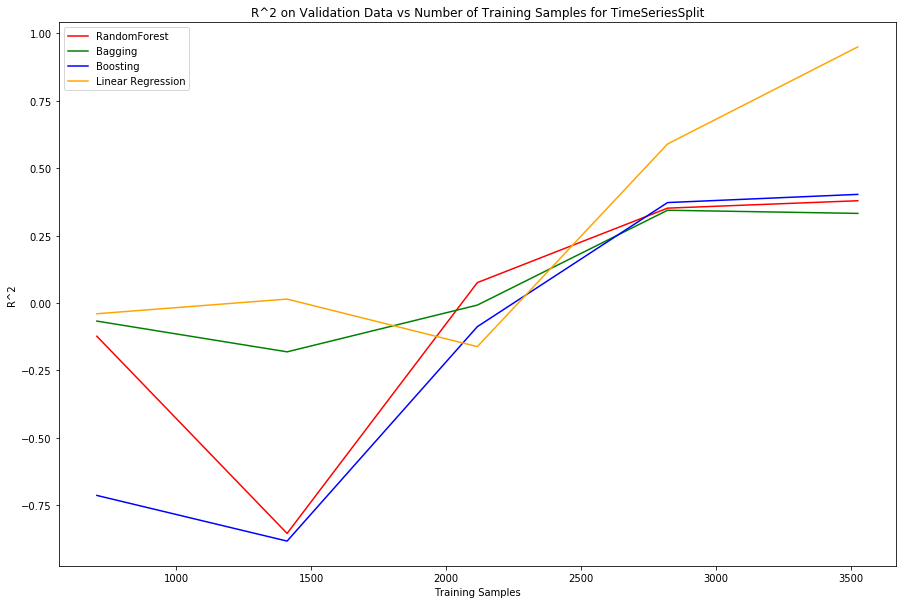

In [236]:
plt.plot(trainsamples,[item[1] for item in model1metrics], color = 'r', label = 'RandomForest')
plt.plot(trainsamples,[item[1] for item in model2metrics], color = 'g', label = 'Bagging')
plt.plot(trainsamples,[item[1] for item in model3metrics], color = 'b', label = 'Boosting')
plt.plot(trainsamples,[item[1] for item in model4metrics], color = 'orange', label = 'Linear Regression')

plt.title('R^2 on Validation Data vs Number of Training Samples for TimeSeriesSplit')
plt.xlabel('Training Samples')
plt.ylabel('R^2')
plt.legend()

plt.rcParams['figure.figsize'] = [15,10]

plt.show()

## All models perform better as training samples increase. Hyperparemeter tune on each of the 4 models on last fold. And do Stacking with LR.

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed:    4.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  15 out of  18 | elapsed:    4.2s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.0s finished


-------------SCORING MODELS-------------


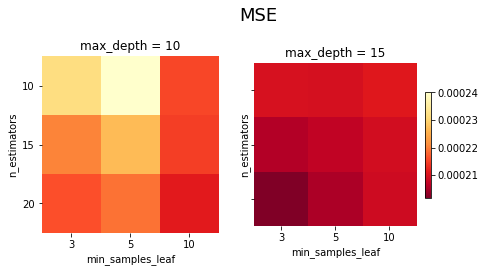

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)


In [238]:
rf = RandomForestRegressor(random_state = 0)

# hyperparameter tuning on randomforest
paramGrid = ParameterGrid({
    'n_estimators': [10,15,20],
    'max_depth' : [10,15],
    'min_samples_leaf': [3,5,10]})
    
best_model, best_score, all_models, all_scores = pf.bestFit(rf, paramGrid, X_train, y_train, X_val, y_val, metric=mean_squared_error, greater_is_better=False, scoreLabel='MSE')
    
print(best_model)

In [ ]:
bag = BaggingRegressor(DecisionTreeRegressor(), random_state = 0)

# hyperparameter tuning on bagging
paramGrid = ParameterGrid({
    'max_features': [10,15,20],
    'n_estimators' : [5,10,15,20],
    })
    
best_model, best_score, all_models, all_scores = pf.bestFit(bag, paramGrid, X_train, y_train, X_val, y_val, metric=mean_squared_error, greater_is_better=False, scoreLabel='MSE')
    
print(best_model)

-------------FITTING MODELS-------------


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:   13.6s remaining:   41.0s
[Parallel(n_jobs=-1)]: Done   3 out of   8 | elapsed:   13.6s remaining:   22.8s
[Parallel(n_jobs=-1)]: Done   4 out of   8 | elapsed:   18.5s remaining:   18.5s
[Parallel(n_jobs=-1)]: Done   5 out of   8 | elapsed:   23.0s remaining:   13.8s
[Parallel(n_jobs=-1)]: Done   6 out of   8 | elapsed:   23.6s remaining:    7.8s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   32.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:   32.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


-------------SCORING MODELS-------------


[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:    0.6s finished


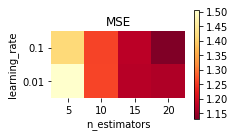

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=0.1, loss='linear', n_estimators=20, random_state=0)


In [40]:
boost = AdaBoostRegressor(DecisionTreeRegressor(), random_state = 0)

# hyperparameter tuning on Boosting
paramGrid = ParameterGrid({
    'learning_rate': [0.1,0.01],
    'n_estimators' : [5,10,15,20],
    })
    
best_model, best_score, all_models, all_scores = pf.bestFit(boost, paramGrid, X_train, y_train, X_val, y_val, metric=mean_squared_error, greater_is_better=False, scoreLabel='MSE')
    
print(best_model)

## STACKING

In [ ]:
# take most optimized model for stacking
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

bag = BaggingRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         bootstrap=True, bootstrap_features=False, max_features=20,
         max_samples=1.0, n_estimators=20, n_jobs=1, oob_score=False,
         random_state=0, verbose=0, warm_start=False)

boost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best'),
         learning_rate=0.1, loss='linear', n_estimators=20, random_state=0)

lr = linear_model.LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

rf.fit(X_train, y_train)
bag.fit(X_train, y_train)
boost.fit(X_train, y_train)
lr.fit(X_train, y_train)

In [82]:
# print('mse level2: ', mean_squared_error(y_val, lr.predict(X_val)))
# print('r2_score: ' , r2_score(y_val, lr.predict(X_val)))

In [ ]:
# stores 4 models prediction in dataframe for training
level1pred = pd.DataFrame()
level1pred['Ticker'] = X_train['Ticker']
level1pred['RF'] = rf.predict(X_train)
level1pred['bag'] = bag.predict(X_train)
level1pred['boost'] = boost.predict(X_train)
level1pred['lr'] = lr.predict(X_train)

In [103]:
# create linear regression 2 for stacking
rf2 = RandomForestRegressor()
rf2.fit(level1pred, y_train)

print('mse level2: ', mean_squared_error(y_train, rf2.predict(level1pred)))
print('r2_score: ' , r2_score(y_train, rf2.predict(level1pred)))

mse level2:  0.0013289659129960192
r2_score:  0.9995851890466074


In [105]:
# stores 4 models prediction in dataframe
level1predval = pd.DataFrame()
level1predval['Ticker'] = X_val['Ticker']
level1predval['RF'] = rf.predict(X_val)
level1predval['bag'] = bag.predict(X_val)
level1predval['boost'] = boost.predict(X_val)
level1predval['lr'] = lr.predict(X_val)

rf2.predict(level1predval)
print('mse level2: ', mean_squared_error(y_val, rf2.predict(level1predval)))
print('r2_score: ' , r2_score(y_val, rf2.predict(level1predval)))

mse level2:  1.1225206672541146
r2_score:  0.6511375083601091


In [106]:
X_val_appl = X_val.loc[X_val['Ticker'] == 0, :]
y_val_appl = y_val[X_val_appl.index]

level1predval_aapl = level1predval.loc[level1predval['Ticker'] == 0, :]

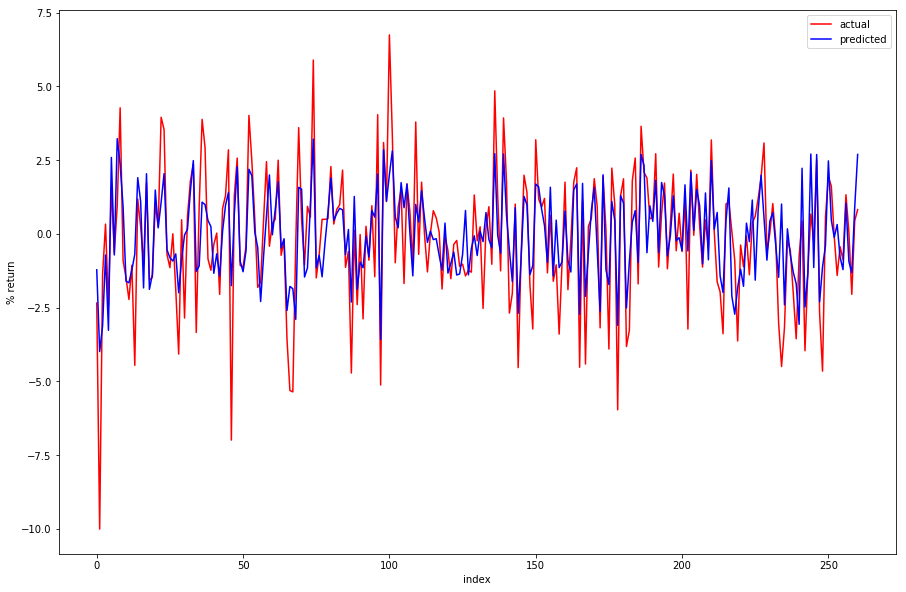

In [107]:
plt.plot(range(0,len(y_val_appl)), y_val_appl, color = 'r', label = 'actual')
plt.plot(range(0,len(y_val_appl)), lr2.predict(level1predval_aapl), color = 'b', label = 'predicted')
plt.legend()

plt.xlabel('index')
plt.ylabel('% return')

plt.savefig('foo.png')
plt.show()